<a href="https://colab.research.google.com/github/G544/galinanana_ml/blob/main/BookCrossing/Neuro_collaborative_filtering_for_Book_Crossing_dataset_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuro collaborative filtering for Book Crossing dataset

Implementation of NCF model for Book Crossing dataset (https://www.kaggle.com/datasets/syedjaferk/book-crossing-dataset)

*Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books*

NCF tries to find intersections between users and items, so we will use only information about ratings for books for each user without demographic user information and books description.
NCF model was built using architecture from "Collaborative Filtering using Deep Neural Networks (in Tensorflow)" article(https://medium.com/@victorkohler/collaborative-filtering-using-deep-neural-networks-in-tensorflow-96e5d41a39a1).

### Uploading data

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"galinanana","key":"cbb73354e6a4418bcb42b7b2ca579b64"}'}

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"galinanana","key":"cbb73354e6a4418bcb42b7b2ca579b64"}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d somnambwl/bookcrossing-dataset
! git clone https://github.com/G544/galinanana_ml.git


 71% 12.0M/16.8M [00:00<00:00, 21.2MB/s]
100% 16.8M/16.8M [00:00<00:00, 28.4MB/s]
Cloning into 'galinanana_ml'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 374 (delta 54), reused 14 (delta 4), pack-reused 240
Receiving objects: 100% (374/374), 21.95 MiB | 19.78 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Import libraries


In [ ]:
# For data reading and preproccessing
import io
import pandas as pd
import zipfile
from pathlib import Path
from galinanana_ml.happy_whale import fit_model

# For creating model and trainig it
import torch
from torch.utils.data import DataLoader
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import mean_absolute_error

from torch.optim import lr_scheduler

### Data reading and preproccessing




In [ ]:
zip_data = zipfile.ZipFile('/content/bookcrossing-dataset.zip')
names = (zip_data.namelist())
books = pd.read_csv(io.BytesIO(zip_data.read(names[0])), sep=';', encoding='latin-1')
ratings = pd.read_csv(io.BytesIO(zip_data.read(names[1])), sep=';', encoding='latin-1')
users = pd.read_csv(io.BytesIO(zip_data.read(names[2])), sep=';', encoding='latin-1')

In [ ]:
books.sample(3)

,ISBN,Title,Author,Year,Publisher
55219,0140422102,John Keats: The Complete Poems,John Keats,1977,Penguin Books
216117,0917102754,Elegant meals with inexpensive meats (Ortho bo...,Cynthia Scheer,1978,Ortho Books
176810,1585421006,Living With Feeling: The Art of Emotional Expr...,Lucia Capacchione,2001,Penguin Putnam


In [ ]:
users.sample(3)

,User-ID,Age
76036,76037,63
212270,212271,44
218492,218493,36


In [ ]:
ratings.sample(3)

,User-ID,ISBN,Rating
6157,278418,0425137562,0
1146793,275970,0425172945,0
1073957,256844,0553579754,7


"User-ID" and "ISBN" are foreign keys for users and books. For intesections model needs only these data. There some duplications through the books and users dataframe. Here we will remove duplicates and Nan values.

In [ ]:
# remove duplicates from books dataframe
books.drop_duplicates(inplace=True)
books1 = books.copy()
books1.reset_index( inplace= True )
ratings_df = ratings.merge(books1[['index','ISBN']],
                           how = 'left', on='ISBN').drop('ISBN', axis=1)
ratings_df.rename(columns={'index':'ISBN'}, inplace=True)

# remove duplicates from users dataframe
users.drop_duplicates(inplace=True)
users1 = users.copy()
users1.reset_index( inplace= True )
users1['User-ID']=users1['User-ID'].astype(str)
ratings_df['User-ID']=ratings['User-ID'].astype(str)
ratings_df = ratings_df.merge(users1[['index','User-ID']],
                           how = 'left', on='User-ID').drop('User-ID', axis=1)
ratings_df.rename(columns={'index':'User-ID'}, inplace=True)

# remove Nan values
ratings_df.dropna(inplace=True)

In [ ]:
ratings_df.sample(3)

,Rating,ISBN,User-ID
566032,10,251250.0,135987
1127796,0,38933.0,270712
73795,9,302.0,15882


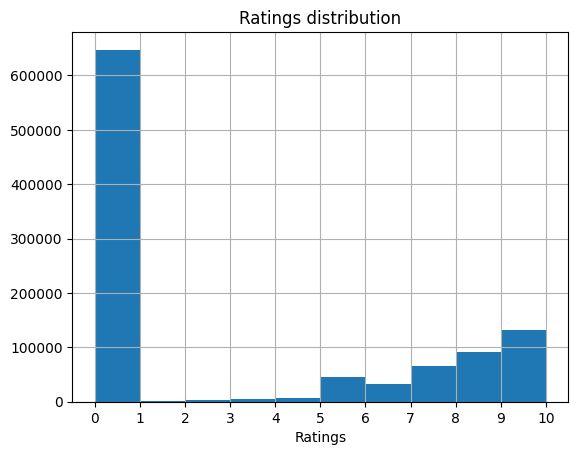

In [ ]:
import matplotlib.pyplot as plt
plt.hist(ratings_df['Rating'], bins = np.unique(ratings_df['Rating']))
plt.title('Ratings distribution')
plt.grid(visible = True)
plt.xlabel('Ratings')
plt.xticks(np.unique(ratings_df['Rating']))
plt.show()

In [ ]:
class BookCrossingDataset(torch.utils.data.Dataset):
    """
    Book Crossing Dataset
    Data preparation
        rating 0 is 0 (0 means implicit rating, not negative)
        ratings less than 4 and more than 1 treat as 1
        ratings 5 and 6 treat than 2
        rating 7 is 7
        rating 8 is 8
        rating 9 is 9
        rating 10 is 10
    """
    def __init__(self, ratings):
        data = ratings.copy().to_numpy()
        self.items = data[:,1:3].astype(np.int32)
        self.targets = torch.from_numpy(self.__preprocess_target(data[:, 0])).type(torch.LongTensor)
        self.field_dims = np.max(self.items, axis=0) + 1
        self.user_field_idx = np.array((1, ), dtype=np.int64)
        self.item_field_idx = np.array((0,), dtype=np.int64)
        self.class_info = dict((classi, number) for classi, number in zip(np.unique(self.targets, return_counts=True)[0],np.unique(self.targets, return_counts=True)[1]))
        self.class_weights = [] # we count class weights for class balance during the train
        for item in self.targets:
          self.class_weights.append(1/self.class_info[int(item)]*10000)


    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, index):
        return self.items[index], self.targets[index]

    def __preprocess_target(self, target):
        target[(target <= 4) & (target>=1)] = 1
        target[(target == 5) | (target == 6)] = 2
        return target
    @property
    def weights_(self ):
      return self.class_weights

## Defining Model


In [ ]:

class NeuralCollaborativeFiltering(torch.nn.Module):
    """
    A pytorch implementation of Neural Collaborative Filtering.

    """

    def __init__(self, field_dims, user_field_idx, item_field_idx, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.user_field_idx = user_field_idx
        self.item_field_idx = item_field_idx
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = torch.nn.Sequential(torch.nn.Linear(self.embed_output_dim, 128),
                            torch.nn.BatchNorm1d(128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(p=dropout),
                            torch.nn.Linear(128, 64),
                            torch.nn.BatchNorm1d(64),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(p=dropout),
                            torch.nn.Linear(64, 32),
                            torch.nn.Linear(32, 16),
                            torch.nn.ReLU())
        self.fc = torch.nn.Linear(16 + embed_dim, 11)
        self.out = torch.nn.Softmax()

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_user_fields)``
        """

        x = self.embedding(x)
        user_x = x[:, self.user_field_idx].squeeze(1)
        item_x = x[:, self.item_field_idx].squeeze(1)
        x = self.mlp(x.view(-1, self.embed_output_dim))
        gmf = user_x * item_x
        x = torch.cat([gmf, x], dim=1)
        x = self.fc(x).squeeze(1)
        return self.out(x)

## Defining training pipeline

In [ ]:
def train(model, optimizer, data_loader, criterion, device, log_interval=100):
    model.train()
    total_loss = 0
    tk0 = tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)
    for i, (fields, target) in enumerate(tk0):
        optimizer.zero_grad()
        fields, target = fields.to(device), target.type(torch.LongTensor).to(device)
        y_prob = model(fields)
        loss = criterion(y_prob, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (i + 1) % log_interval == 0:
            tk0.set_postfix(loss=total_loss / log_interval)
            total_loss = 0
    return total_loss

In [ ]:
def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y_prob = model(fields)
            y = torch.argmax(y_prob,-1)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())
    return round(mean_absolute_error(targets, predicts), 6)

## Splitting the data, setting weighted sampler and creating the dataloaders.

In [ ]:
batch_size = 64
dataset =  BookCrossingDataset(ratings_df)
data = ratings_df
train_dataset, test_valid = train_test_split(data, train_size = 0.8, test_size = 0.2)
test_dataset, valid_dataset =  train_test_split(test_valid, train_size = 0.5, test_size = 0.5)

train_dataset = BookCrossingDataset(train_dataset)
test_dataset = BookCrossingDataset(test_dataset)
valid_dataset = BookCrossingDataset(valid_dataset)

sampler = WeightedRandomSampler(weights = train_dataset.weights_, num_samples = len(train_dataset))
train_data_loader = DataLoader((train_dataset), sampler=sampler, batch_size=batch_size) #
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size)

## Setting parameters for model

In [ ]:
device_cpu = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
learning_rate = 1e-4
weight_decay = 1e-5
epochs = 45
device = torch.device(device_cpu)

In [ ]:
field_dims = dataset.field_dims
model = NeuralCollaborativeFiltering(field_dims, embed_dim=64, mlp_dims=(32, 32), dropout=0.2,
                                       user_field_idx=dataset.user_field_idx,
                                       item_field_idx=dataset.item_field_idx)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=35, gamma=0.1)

## Fit model

In [ ]:
loss_list =  []
valid_mae = []
for epoch_i in range(epochs):
    loss_list.append(train(model, optimizer, train_data_loader, criterion, device)/100)
    mae = test(model, valid_data_loader, device)
    valid_mae.append(mae)
    exp_lr_scheduler.step()
    print('epoch:', epoch_i, 'validation: mae:', mae)

100%|██████████| 1612/1612 [00:02<00:00, 779.74it/s]


epoch: 0 validation: mae: 3.545841


100%|██████████| 1612/1612 [00:02<00:00, 794.07it/s]


epoch: 1 validation: mae: 3.571084


100%|██████████| 1612/1612 [00:02<00:00, 618.24it/s]


epoch: 2 validation: mae: 3.580122


100%|██████████| 1612/1612 [00:01<00:00, 819.07it/s]


epoch: 3 validation: mae: 3.562627


100%|██████████| 1612/1612 [00:02<00:00, 777.23it/s]


epoch: 4 validation: mae: 3.62186


100%|██████████| 1612/1612 [00:01<00:00, 828.72it/s]


epoch: 5 validation: mae: 3.686582


100%|██████████| 1612/1612 [00:02<00:00, 796.49it/s]


epoch: 6 validation: mae: 3.657945


100%|██████████| 1612/1612 [00:02<00:00, 599.80it/s]


epoch: 7 validation: mae: 3.601234


100%|██████████| 1612/1612 [00:01<00:00, 816.44it/s]


epoch: 8 validation: mae: 3.701972


100%|██████████| 1612/1612 [00:02<00:00, 751.74it/s]


epoch: 9 validation: mae: 3.713988


100%|██████████| 1612/1612 [00:01<00:00, 818.41it/s]


epoch: 10 validation: mae: 3.640305


100%|██████████| 1612/1612 [00:01<00:00, 827.82it/s]


epoch: 11 validation: mae: 3.642342


100%|██████████| 1612/1612 [00:02<00:00, 685.63it/s]


epoch: 12 validation: mae: 3.641149


100%|██████████| 1612/1612 [00:01<00:00, 827.09it/s]


epoch: 13 validation: mae: 3.69659


100%|██████████| 1612/1612 [00:01<00:00, 813.66it/s]


epoch: 14 validation: mae: 3.663647


100%|██████████| 1612/1612 [00:02<00:00, 797.53it/s]


epoch: 15 validation: mae: 3.617797


100%|██████████| 1612/1612 [00:01<00:00, 817.82it/s]


epoch: 16 validation: mae: 3.683023


100%|██████████| 1612/1612 [00:02<00:00, 632.34it/s]


epoch: 17 validation: mae: 3.615828


100%|██████████| 1612/1612 [00:02<00:00, 803.58it/s]


epoch: 18 validation: mae: 3.559747


100%|██████████| 1612/1612 [00:02<00:00, 613.07it/s]


epoch: 19 validation: mae: 3.657567


100%|██████████| 1612/1612 [00:02<00:00, 801.82it/s]


epoch: 20 validation: mae: 3.63663


100%|██████████| 1612/1612 [00:02<00:00, 588.95it/s]


epoch: 21 validation: mae: 3.522382


100%|██████████| 1612/1612 [00:02<00:00, 805.63it/s]


epoch: 22 validation: mae: 3.533321


100%|██████████| 1612/1612 [00:02<00:00, 668.40it/s]


epoch: 23 validation: mae: 3.491815


100%|██████████| 1612/1612 [00:01<00:00, 809.04it/s]


epoch: 24 validation: mae: 3.543601


100%|██████████| 1612/1612 [00:02<00:00, 611.57it/s]


epoch: 25 validation: mae: 3.492193


100%|██████████| 1612/1612 [00:02<00:00, 781.64it/s]


epoch: 26 validation: mae: 3.499738


100%|██████████| 1612/1612 [00:02<00:00, 612.83it/s]


epoch: 27 validation: mae: 3.4737


100%|██████████| 1612/1612 [00:02<00:00, 789.56it/s]


epoch: 28 validation: mae: 3.523643


100%|██████████| 1612/1612 [00:02<00:00, 704.62it/s]


epoch: 29 validation: mae: 3.459852


100%|██████████| 1612/1612 [00:02<00:00, 799.20it/s]


epoch: 30 validation: mae: 3.523274


100%|██████████| 1612/1612 [00:02<00:00, 779.72it/s]


epoch: 31 validation: mae: 3.483931


100%|██████████| 1612/1612 [00:02<00:00, 697.97it/s]


epoch: 32 validation: mae: 3.469724


100%|██████████| 1612/1612 [00:02<00:00, 798.27it/s]


epoch: 33 validation: mae: 3.486278


100%|██████████| 1612/1612 [00:02<00:00, 739.19it/s]


epoch: 34 validation: mae: 3.438275


100%|██████████| 1612/1612 [00:02<00:00, 803.39it/s]


epoch: 35 validation: mae: 3.460211


100%|██████████| 1612/1612 [00:02<00:00, 687.98it/s]


epoch: 36 validation: mae: 3.38069


100%|██████████| 1612/1612 [00:02<00:00, 790.52it/s]


epoch: 37 validation: mae: 3.426007


100%|██████████| 1612/1612 [00:02<00:00, 619.80it/s]


epoch: 38 validation: mae: 3.434143


100%|██████████| 1612/1612 [00:02<00:00, 597.40it/s]


epoch: 39 validation: mae: 3.420809


100%|██████████| 1612/1612 [00:02<00:00, 605.69it/s]


epoch: 40 validation: mae: 3.428761


100%|██████████| 1612/1612 [00:02<00:00, 747.41it/s]


epoch: 41 validation: mae: 3.483679


100%|██████████| 1612/1612 [00:02<00:00, 704.62it/s]


epoch: 42 validation: mae: 3.495879


100%|██████████| 1612/1612 [00:02<00:00, 764.69it/s]


epoch: 43 validation: mae: 3.41534


100%|██████████| 1612/1612 [00:02<00:00, 674.85it/s]

epoch: 44 validation: mae: 3.450212


In [ ]:
torch.save(model, 'new_model_3_45.pt')

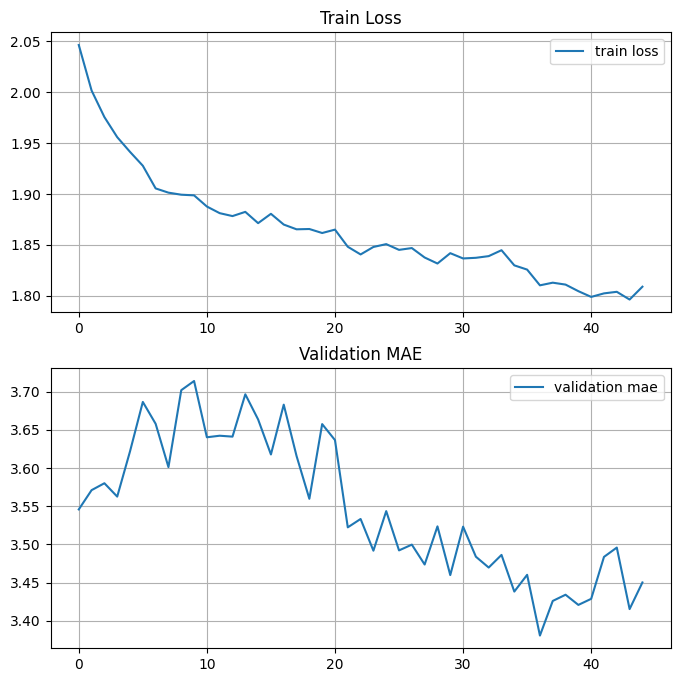

In [ ]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(loss_list, label="train loss")
ax[0].legend()
ax[0].grid(linestyle="-")
ax[0].set_title('Train Loss')
ax[1].plot(valid_mae, label="validation mae")
ax[1].legend()
ax[1].grid(linestyle="-")
ax[1].set_title('Validation MAE')
plt.show()

In [ ]:
test_mae =  test(model, test_data_loader, device)
print(' ')
print(f'Test MAE: {test_mae}')

100%|██████████| 1612/1612 [00:02<00:00, 786.15it/s]

 
Test MAE: 3.437348
